##***DeepFake Detection Using Deep Learning***




## **Setup and Library Imports**

In [1]:
import os
import glob
import json
import copy
import random
import time
import sys
import torch
import cv2
from torch import nn
import seaborn as sn
import pandas as pd
import numpy as np
import torchvision

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt 
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
seed=40302
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## **Helper Functions**

In [3]:
#Function to plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [4]:
def calculate_accuracy(outputs, targets):

    batch_size = targets.size(0)
    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1,-1))
    accuracy = (correct.float().sum().item() / batch_size) * 100
    return accuracy

In [5]:
class AverageMeter(object):
    '''Computes and stores average and current value
    '''
    def __init__(self):
        self.reset()
    def reset(self):
        self.count = 0
        self.sum = 0
        self.val = 0
        self.avg = 0

    def update(self, val, n = 1): 
        self.count += n
        self.sum += val * n
        self.val = val
        self.avg = self.sum / self.count

In [6]:
def print_confusion_matrix(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print('True positives = ', cm[0][0])
    print('False positives = ', cm[0][1])
    print('False negatives = ', cm[1][0])
    print('True negatives = ', cm[1][1])
    print('\n')
    print('Accuracy: ',calculated_acc*100)
    print('Precision: ', cm[0][0]/(cm[0][1] + cm[0][0]))
    print('Recall: ', cm[0][0]/(cm[1][0] + cm[0][0]))

In [7]:
#Function for plotting loss and accuracy
def plot_loss(train_loss_avg, test_loss_avg, num_epochs):

    loss_train = train_loss_avg
    loss_val = test_loss_avg

    epochs = range(num_epochs)
    plt.plot(epochs, loss_train, 'g', label='Training')
    plt.plot(epochs, loss_val, 'b', label='validation')
    plt.title('Training and Validation losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(train_accuracy, test_accuracy, num_epochs):

    loss_train = train_accuracy
    loss_val = test_accuracy
    epochs = range(num_epochs)
    plt.plot(epochs, loss_train, 'g', label='Training ')
    plt.plot(epochs, loss_val, 'b', label='validation ')
    plt.title('Training and Validation accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## **Data Reading, Splitting and Loading**

In [8]:
dfdc_folders = glob.glob(os.getcwd() + '\\dfdc\\dfdc*')
dfdc_folders = sorted(dfdc_folders, key=lambda x: x)
all_dataframes = []
for train_dir in dfdc_folders:
    df = pd.read_csv(os.path.join(train_dir, 'metadata.csv'))
    df['path'] = df['filename'].apply(lambda x: os.path.join(train_dir, x.split('.')[0]))
    all_dataframes.append(df)

dfdc_df = pd.concat(all_dataframes, ignore_index=True, sort=False)


In [30]:
dfdc_df.label.value_counts()

FAKE    8486
REAL    1012
Name: label, dtype: int64

In [9]:
dfdc_df['origin'] = 'dfdc'
dfdc_df.drop(['split', 'original'],axis=1, inplace=True)
dfdc_df.head()

,filename,label,path,origin
0,crnkpgykgj.mp4,FAKE,h:\project\dfdc\dfdc_part3_0\crnkpgykgj,dfdc
1,buhvwnaupu.mp4,FAKE,h:\project\dfdc\dfdc_part3_0\buhvwnaupu,dfdc
2,rvrlzxepiu.mp4,FAKE,h:\project\dfdc\dfdc_part3_0\rvrlzxepiu,dfdc
3,atvucyyltw.mp4,FAKE,h:\project\dfdc\dfdc_part3_0\atvucyyltw,dfdc
4,emxknhlufj.mp4,FAKE,h:\project\dfdc\dfdc_part3_0\emxknhlufj,dfdc


In [10]:
celeb_df =  pd.read_csv('./celeb_metadata.csv')

In [11]:
celeb_df['path'] = celeb_df['Unnamed: 0'].apply(lambda x: os.path.join('h:\\project\\CelebDF-v2\\faces', x.split('.')[0]))
celeb_df.drop(['img_dir', 'fullpath'], axis=1, inplace=True)
celeb_df.rename(columns={'Unnamed: 0':'filename'}, inplace=True)
celeb_df = celeb_df[['filename', 'label', 'path', 'origin']]
celeb_df.head()

,filename,label,path,origin
0,id0_0000.mp4,REAL,h:\project\CelebDF-v2\faces\id0_0000,CelebDF-v2
1,id0_0001.mp4,REAL,h:\project\CelebDF-v2\faces\id0_0001,CelebDF-v2
2,id0_0002.mp4,REAL,h:\project\CelebDF-v2\faces\id0_0002,CelebDF-v2
3,id0_0003.mp4,REAL,h:\project\CelebDF-v2\faces\id0_0003,CelebDF-v2
4,id0_0004.mp4,REAL,h:\project\CelebDF-v2\faces\id0_0004,CelebDF-v2


In [12]:
celeb_df.shape

(6529, 4)

We get the test samples listed by the Celeb_DF2 for testing

In [13]:
df2 = pd.read_csv('./CelebDF-v2/List_of_testing_videos.txt', delimiter=' ', header=None)
df2[1] = df2[1].apply(lambda s: s.split('/')[-1])
df2.shape

(518, 2)

In [14]:
test_celeb = celeb_df.loc[celeb_df.filename.isin(df2[1].tolist())].reset_index(drop=True)
celeb_df.drop(test_celeb.index, inplace=True)
celeb_df.reset_index(drop=True, inplace=True)
test_celeb.label.value_counts()

FAKE    340
REAL    178
Name: label, dtype: int64

In [15]:
celeb_df.shape

(6011, 4)

In [37]:
ytf_df = pd.read_csv('./youtube_faces_dataset/youtube_faces_50f.csv')
ytf_df['label'] = 'REAL'
ytf_df['origin'] = 'ytf'
ytf_df['path'] = ytf_df['videoID'].apply(lambda x: os.path.join('./youtube_faces_dataset/faces', x))
ytf_df.head()

ytf_df.drop(['Unnamed: 0', 'personName', 'imageHeight', 'imageWidth', 'videoDuration', 'averageFaceSize', 'numVideosForPerson'], axis=1, inplace=True)
ytf_df.rename(columns={'videoID':'filename'}, inplace=True)
ytf_df = ytf_df[['filename', 'label', 'path', 'origin']]
ytf_df.head()

,filename,label,path,origin
0,Alison_Lohman_0,REAL,./youtube_faces_dataset/faces\Alison_Lohman_0,ytf
1,Alison_Lohman_1,REAL,./youtube_faces_dataset/faces\Alison_Lohman_1,ytf
2,Alison_Lohman_2,REAL,./youtube_faces_dataset/faces\Alison_Lohman_2,ytf
3,Alison_Lohman_3,REAL,./youtube_faces_dataset/faces\Alison_Lohman_3,ytf
4,Alison_Lohman_4,REAL,./youtube_faces_dataset/faces\Alison_Lohman_4,ytf


In [38]:
x = [False for n in range(len(ytf_df.path))]
for i,path in enumerate(ytf_df.path.tolist()):
    already_present_count =  len(glob.glob(path+'/*'))
    if already_present_count >= 50:
        x[i] = True
ytf_df = ytf_df[x].reset_index(drop=True)
ytf_df.shape

(1618, 4)

In [75]:
df = pd.concat([dfdc_df, celeb_df, ytf_df ], ignore_index=True, sort=False)
df.label.value_counts()

FAKE    14125
REAL     3002
Name: label, dtype: int64

In [76]:
df.origin.value_counts()

dfdc          9498
CelebDF-v2    6011
ytf           1618
Name: origin, dtype: int64

Dealing with class imbalance

We will use first 50 frames for each video, but for DFDC we have 300 frames available and for CelebDF-v2 150 frames so we will create additional rows for subsequent blocks of 50 frames in the video

Additionaly we will use inverted frame for all real samples to duplicate all data

In [77]:
df['frames'] = 1
df['inv_frame'] = 0

In [78]:
real_dfdc = df[(df['label'] == 'REAL') & (df['origin'] == 'dfdc')].reset_index(drop=True)

real_celeb = df[(df['label'] == 'REAL') & (df['origin'] == 'CelebDF-v2')].reset_index(drop=True)

In [79]:
for i in range(2,3):
    if i <= 3:
        real_celeb.frames = i
        real_celeb_i = real_celeb.copy()
        real_celeb_i.inv_frame = 1
        df = pd.concat([df, real_celeb_i], ignore_index=True, sort=False)
    real_dfdc.frames = i
    real_dfdc_i = real_dfdc.copy()
    real_dfdc_i.inv_frame = 1
    df = pd.concat([df, real_dfdc_i], ignore_index=True, sort=False)

Next we undersample the fake videos to allow the classes to be balanced

In [80]:
df.drop(df[(df['label'] == 'FAKE') & (df['origin'] == 'dfdc')].sample(7000).index, inplace=True)


df.drop(df[(df['label'] == 'FAKE') & (df['origin'] == 'CelebDF-v2')].sample(2000).index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [81]:
df.label.value_counts()

FAKE    5125
REAL    4386
Name: label, dtype: int64

In [82]:
df.origin.value_counts()

CelebDF-v2    4383
dfdc          3510
ytf           1618
Name: origin, dtype: int64

In [83]:
df.tail()

,filename,label,path,origin,frames,inv_frame
9506,bfajruognp.mp4,REAL,h:\project\dfdc\dfdc_part_2_2\bfajruognp,dfdc,2,1
9507,qooxnxqqjb.mp4,REAL,h:\project\dfdc\dfdc_part_2_2\qooxnxqqjb,dfdc,2,1
9508,pdswwyyntw.mp4,REAL,h:\project\dfdc\dfdc_part_2_2\pdswwyyntw,dfdc,2,1
9509,nawtezpgnm.mp4,REAL,h:\project\dfdc\dfdc_part_2_2\nawtezpgnm,dfdc,2,1
9510,ziipxxchai.mp4,REAL,h:\project\dfdc\dfdc_part_2_2\ziipxxchai,dfdc,2,1


define a function to get stratified split of train/test split 

In [84]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

def get_split(data, size=0.2):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=size, random_state=seed)

  for a,b in sss.split(np.arange(data.shape[0]), data.label):
    train_idx, test_idx = a,b 

  return train_idx, test_idx

Separate 30% of the sample of DFDC as test set too

In [85]:
_, dfdc_test = get_split(df, 0.2)
test_df = df.loc[dfdc_test, :]
test_df.shape

(1903, 6)

Separate 30% of the remaining combined dataframe as validation set 

In [86]:
df.drop(dfdc_test, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(7608, 6)

In [87]:
train_idx, val_idx = get_split(df, 0.2)
train_df = df.loc[train_idx,:].reset_index(drop=True)
valid_df = df.loc[val_idx,:].reset_index(drop=True)

In [88]:
train_df.label.value_counts()

FAKE    3280
REAL    2806
Name: label, dtype: int64

In [89]:
valid_df.label.value_counts()

FAKE    820
REAL    702
Name: label, dtype: int64

Custom Dataset Definition


inside video dataset we'll deal with class imbalance


In [90]:
#Augment the data by applying transformations to train and test set
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transforms_inv = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.RandomHorizontalFlip(p=1.0),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomRotation(20),
                                        transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.5, 0.5)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomRotation(10),
                                        transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.5, 0.5)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])


test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

In [102]:
from glob import glob

class video_dataset(Dataset):
    def __init__(self, df, frames_to_uses = 50, transform = None):
        assert frames_to_uses <= 50, 'please use max 50 frames'
            
        self.data = df.reset_index(drop=True).copy()
        self.transform = transform
        self.count = frames_to_uses
        self.labels = self.data['label'].values
        self.transforms_inv = transforms_inv
    
    
    def __len__(self):
        return self.data.shape[0]
    
    
    def __getitem__(self,idx):
        path = self.data['path'][idx] + '/*.png'
        img_list = glob(path)
        frames=[]
        print(len(path))
        print()
        #setup the correct starting frame according with the frame block set in the dataframe
        frame_idx = self.data['frames'][idx]

        start_frame = (frame_idx-1)*self.count
        if len(img_list[start_frame:]) < self.count:
            start_frame = len(img_list[start_frame:])-1 - self.count
        end_frame = start_frame+self.count-1

        #get label
        label = self.labels[idx]

        if(label == 'FAKE'):
            label = 0
        if(label == 'REAL'):
            label = 1
            
        #put frames of the folder in a list   
        #for i,img_path in enumerate(img_list):
        for i in range(start_frame, end_frame+1):
            image = cv2.imread(img_list[i], cv2.IMREAD_COLOR)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.data['inv_frame'][idx]:
                frames.append(self.transforms_inv(image))
            else: 
                frames.append(self.transform(image))
            if(len(frames) == self.count):
                break
        frames = torch.stack(frames)

        return frames,label
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


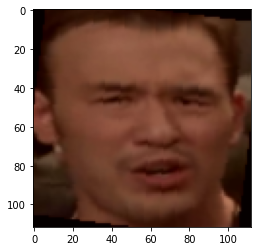

In [92]:
#preprocess the data
train_data = video_dataset(train_df, frames_to_uses = 50,transform = train_transforms)
val_data = video_dataset(valid_df, frames_to_uses = 50, transform = test_transforms)

#load the data into dataloaders
train_loader = DataLoader(train_data, batch_size = 4, shuffle = True, num_workers = 0)
valid_loader = DataLoader(val_data, batch_size = 4, shuffle = True, num_workers = 0)

#plot the data
image,label = train_data[3987]
im_plot(image[49,:,:,:])

## **Model 1 : Convolution Neural Network**

In [231]:
#Baseline CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3,32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(32,32, kernel_size=(3, 3))
        self.max1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(32,64, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(64,64, kernel_size=(3, 3))
        self.max2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv5 = nn.Conv2d(64,128, kernel_size=(3, 3))
        self.conv6 = nn.Conv2d(128,128, kernel_size=(3, 3))
        self.max3 = nn.AvgPool2d(kernel_size=(2, 2))

        self.drop = nn.Dropout(p=0.3)

        # 4x dense layers to learn from features extracted from convolutions
        self.l1 = nn.Linear(12800,584)
        self.l2 = nn.Linear(584,128)
        self.l3 = nn.Linear(128,32)
        self.l4 = nn.Linear(32,2) 

    def forward(self, x):
                
        batch_size,seq_length, c, h, w = x.shape

        x = x.view(batch_size * seq_length, c, h, w)

        x = F.relu(self.conv1(x)) 
        x = F.relu(self.conv2(x))
        x = self.max1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.max2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.max3(x)  
              
        x = x.view(x.shape[0],-1)
        
        x = F.leaky_relu(self.l1(x))   
        x = F.leaky_relu(self.l2(x))
        x = self.drop(x)
        x = F.relu(self.l3(x))
        x = self.l4(x)
        output = F.softmax(x, dim=1)
        return output


In [93]:
#Model with Pretrained Efficient Net with GRU 
class Efficientnet(nn.Module):
    def __init__(self, num_classes):
        super(Efficientnet, self).__init__()
        model = models.efficientnet_b0(pretrained = True) #Pretrained Efficient Net b0 Model

        n_inputs = model.classifier[1].in_features
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.linear1 = nn.Linear(n_inputs ,256)
        self.linear2 = nn.Linear(256,128)
        self.dp = nn.Dropout(0.3)
        self.linear3 = nn.Linear(128,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
    def forward(self, x):

        batch_size,frames_to_use, c, h, w = x.shape 
        x = x.view(batch_size * frames_to_use, c, h, w)
        fmap = self.model(x)

        x = self.avgpool(fmap)
        x = x.view(x.shape[0],-1)
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.dp(self.linear2(x)))
        x = self.linear3(x)

        output = F.softmax(x, dim=1)

        return output

In [94]:
#instantiate the model
model1 = Efficientnet(2).cuda()
#model1 = CNNModel().cuda()

C:\Users\leovc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\leovc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [95]:
print(model1)

Efficientnet(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation)

In [96]:
#train function for CNN Model
def train_epoch(epoch, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    
    for i, (inputs, targets) in pbar:
       
        
        targets = targets.type(torch.cuda.LongTensor)
        inputs = inputs.cuda()

        bs,frames_to_use, *_= inputs.shape
        outputs = model(inputs)   #call the model with inputs
        results = torch.zeros((bs,2)).cuda()
        
        #takes each sequence of frames that composes one video and calculate the mean output as the result
        for k, j in enumerate(range(0,bs*frames_to_use,frames_to_use)):
            results[k] = torch.mean(outputs[j:j+frames_to_use],dim=0)   
        
        #calculate loss and accuracy

        loss  = criterion(results,targets)  
        acc = calculate_accuracy(results, targets)
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #add comment to progress bar 
        description = f'epoch {epoch} loss: {losses.avg:.4f} {accuracies.avg:.2f}'   
        pbar.set_description(description)
    
    return losses.avg,accuracies.avg

#validate function
def run_inference(model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        
        pbar = tqdm(enumerate(data_loader), total=len(data_loader))
        
        for i, (inputs, targets) in pbar:

            targets = targets.cuda().type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
           
            bs,frames_to_use, *_ = inputs.shape
            outputs = model(inputs)
            results = torch.zeros((bs,2)).cuda()

            for k, j in enumerate(range(0,bs*frames_to_use,frames_to_use)):
                results[k] = torch.mean(outputs[j:j+frames_to_use],dim=0)
            
            loss = torch.mean(criterion(results, targets))
            acc = calculate_accuracy(results,targets)
            _,p = torch.max(results,1) 
            true += (targets).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

        print('\nAccuracy {}'.format(accuracies.avg))
        
    return true,pred,losses.avg,accuracies.avg

In [97]:
#learning rate
lr = 0.001

#number of epochs 
num_epochs = 12

optimizer = torch.optim.Adam(model1.parameters(), lr= lr, weight_decay = 1e-5)

criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
val_loss_avg = []
val_accuracy = []
best_accuracy = 0
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,train_loader,model1,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    #validation step
    true,pred,tl,t_acc = run_inference(model1,valid_loader,criterion)
    val_loss_avg.append(tl)
    val_accuracy.append(t_acc)
    if t_acc > best_accuracy:
        best_accuracy = t_acc
        torch.save(model1.state_dict(),'./effnet_{}.pt'.format(epoch))
    

  0%|          | 0/1522 [00:00<?, ?it/s]

Testing


  0%|          | 0/381 [00:00<?, ?it/s]


Accuracy 80.09198423127464


  0%|          | 0/1522 [00:00<?, ?it/s]

Testing


  0%|          | 0/381 [00:00<?, ?it/s]


Accuracy 86.59658344283837


  0%|          | 0/1522 [00:00<?, ?it/s]

Testing


  0%|          | 0/381 [00:00<?, ?it/s]


Accuracy 85.9395532194481


  0%|          | 0/1522 [00:00<?, ?it/s]

Testing


  0%|          | 0/381 [00:00<?, ?it/s]


Accuracy 87.25361366622865


  0%|          | 0/1522 [00:00<?, ?it/s]

Testing


  0%|          | 0/381 [00:00<?, ?it/s]


Accuracy 86.2023653088042


  0%|          | 0/1522 [00:00<?, ?it/s]

Testing


  0%|          | 0/381 [00:00<?, ?it/s]


Accuracy 85.742444152431


  0%|          | 0/1522 [00:00<?, ?it/s]

Testing


  0%|          | 0/381 [00:00<?, ?it/s]


Accuracy 86.59658344283837


  0%|          | 0/1522 [00:00<?, ?it/s]

Testing


  0%|          | 0/381 [00:00<?, ?it/s]


Accuracy 88.89618922470433


  0%|          | 0/1522 [00:00<?, ?it/s]

Testing


  0%|          | 0/381 [00:00<?, ?it/s]


Accuracy 90.473061760841


  0%|          | 0/1522 [00:00<?, ?it/s]

Testing


  0%|          | 0/381 [00:00<?, ?it/s]


Accuracy 85.54533508541392


  0%|          | 0/1522 [00:00<?, ?it/s]

Testing


  0%|          | 0/381 [00:00<?, ?it/s]


Accuracy 83.50854139290408


  0%|          | 0/1522 [00:00<?, ?it/s]

Testing


  0%|          | 0/381 [00:00<?, ?it/s]


Accuracy 88.107752956636


In [245]:
test_data = video_dataset(test_df, frames_to_uses = 50, transform = test_transforms)
tst_loader = DataLoader(test_data, batch_size = 2, shuffle = True, num_workers = 0)
criterion = nn.CrossEntropyLoss().cuda()
true,pred,tl,t_acc = run_inference(model1,tst_loader,criterion)

Testing


  0%|          | 0/928 [00:00<?, ?it/s]


Accuracy 85.98382749326146


In [99]:
test_celeb.label.value_counts()

FAKE    340
REAL    178
Name: label, dtype: int64

In [104]:
test_celeb['frames'] = 1
test_celeb['inv_frame'] = 0

test_data = video_dataset(test_celeb, frames_to_uses = 50, transform = test_transforms)
tst_loader = DataLoader(test_data, batch_size = 2, shuffle = True, num_workers = 0)
criterion = nn.CrossEntropyLoss().cuda()
run_inference(model1,tst_loader,criterion)



Testing


  0%|          | 0/259 [00:00<?, ?it/s]

43
42
43
46
47
46
39
48
48
48
47
47
48
47
43
39
48
39
48
39
48
48
47
48
39
48
46
39
39
48
43
48
39
48
42
47
48
46
48
48
43
48
48
48
48
48
43
43
48
48
39
43
39
42
47
48
47
48
47
39
39
46
42
48
42
48
43
48
43
48
43
48
39
47
43
47
47
48
48
39
43
48
48
47
48
39
48
43
48
39
43
47
48
47
46
39
48
48
48
47
47
39
48
47
43
39
39
48
48
46
47
48
39
43
48
39
43
46
48
43
42
47
39
43
48
47
48
47
48
48
43
48
48
46
43
39
47
39
48
46
47
48
43
43
39
46
39
47
47
47
46
48
47
46
43
47
48
43
43
48
48
48
48
48
47
42
48
48
46
39
48
48
48
48
48
48
43
47
46
39
43
42
48
46
47
47
48
46
48
48
46
47
48
46
48
48
48
47
48
47
39
39
43
43
48
48
43
48
48
43
39
47
48
48
46
48
48
48
47
43
43
48
39
47
39
46
43
43
43
48
43
47
43
43
47
46
47
43
47
48
39
48
46
48
43
47
48
48
47
46
47
47
46
48
43
39
46
47
43
48
39
47
48
42
47
43
48
48
48
47
47
47
48
47
43
47
48
43
46
47
39
48
39
39
43
47
43
39
48
39
47
48
43
46
48
43
47
46
47
47
48
43
47
43
43
47
46
48
39
48
47
48
48
39
46
39
43
48
39
47
39
39
42
48
48
43
43
47
48
46
48
48
48
3

([1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


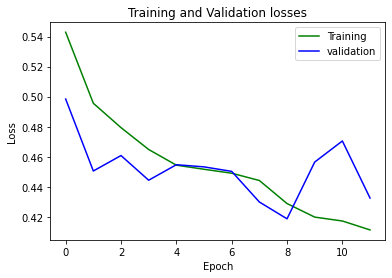

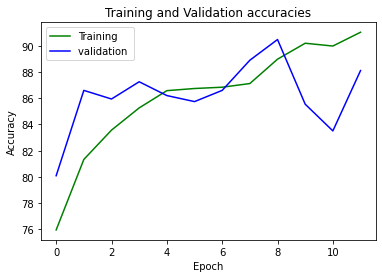

In [98]:
#plot of loss and accuracy for CNN
plot_loss(train_loss_avg,val_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,val_accuracy,len(train_accuracy))

[[676 144]
 [ 37 665]]


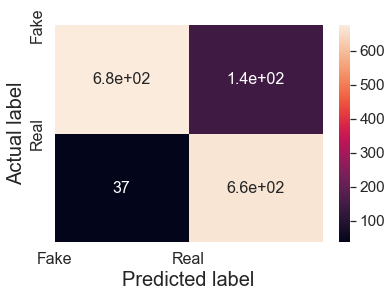

True positives =  676
False positives =  144
False negatives =  37
True negatives =  665


Accuracy:  88.107752956636
Precision:  0.824390243902439
Recall:  0.9481065918653576


In [100]:
#confusion matrix for CNN 
print(confusion_matrix(true,pred)) 
print_confusion_matrix(true,pred) 